# 第11回 機械学習入門2 勾配降下法、ロジスティック回帰、クラスタリング


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

## 勾配降下法

機械学習においては損失関数 $L(\mathbf{w})$ の最小化問題

$$ \tag{1}
  \min_{\mathbf{w}} L(\mathbf{w})
$$

を解くことが鍵となる。例えば、線形回帰モデルにおいては、損失関数は

$$
  L(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^N\left(y_i - w_0 - \sum_{j=1}^Dw_jx_{ij}\right)^2 =\frac{1}{N}\sum_{i=1}^N\left(y_i - \mathbf{w}^T \mathbf{x}_i\right)^2
$$

であった。線形回帰の場合など $\nabla L(\mathbf{w})=0$ が解析的に解ける、すなわち $\textbf{w}=\cdots$ という表現を得られることがある。
しかし、機械学習ではデータの個数・次元が非常に大きく、解析的表現による解法は実用的ではないことが多い。
そこで、反復法を用いて(1)を解くことが多い。

もし $\mathbf{w}^*$が(1)の解であるならば

$$ \tag{2}
  \nabla L(\mathbf{w}^*) = 0
$$

を満たす。ここで $\nabla L(\mathbf{w})$ は勾配ベクトルで

$$
  \nabla L(\mathbf{w})=\left(\frac{\partial L}{\partial w_1}\left(\mathbf{w}\right),\frac{\partial L}{\partial w_2}\left(\mathbf{w}\right),\ldots,\frac{\partial L}{\partial w_D}\left(\mathbf{w}\right)\right)^T
$$

により定義される。
ここで、$D$はベクトル$\mathbf{w}$の要素数を表す。$\mathbf{w}$ が1次元の場合は通常の微分 $L'(w)$ である。

しかし、ある $\mathbf{w}$ が (2) を満たしたとしても，
それが最小化問題 (1) の解になるとは限らず、
局所的最適解になっている可能性がある。

[大域的最適解と局所的最適解の図を挿入]

局所的最適解に対して、(1)の解を大域的最適解と呼ぶ。
関数 $L$ が凸関数であるときには、条件(2)を満たす $\mathbf{w}$ は大域的最適解になる。
関数 $L$ が条件

$$
  L(t\mathbf{w}_1+\left(1-t\right)\mathbf{w}_2) \leq t L(\mathbf{w}_1)+(1-t)L(\mathbf{w}_2),\ \forall t\in\left[0,1\right],\ \ \forall\mathbf{w}_1,\mathbf{w}_2  
$$

を満たすとき、凸関数であるという。

[凸関数の図を挿入]

いくつかのモデルでは損失関数は凸関数となるが、ニューラルネットワークなどでは損失関数が必ずしも凸にならないので、注意が必要となる。
非凸関数に対して(1)を解くことは一般には難しく、
通常は局所的最適解を求めることで満足することが多い。
以下でも、局所最適解を求める手法のみを考える。

勾配ベクトル $\nabla L$ の情報をもとに (1) の解を近似する手法を
**勾配降下法**という。
一般に実数値関数 $f(\mathbf{w})$ について、ベクトル $\mathbf{d}$ に対して，
ある実数 $\eta > 0$ が存在して$f(\mathbf{w}+\eta\mathbf{d})<f(\mathbf{w})$
となるとき、ベクトル $\mathbf{d}$ を $\mathbf{w}$ における降下方向とよぶ。

$\nabla f(\mathbf{w})^T \mathbf{d}<0$ を満たす $\mathbf{d}$ は降下方向である。
なぜなら、十分小さく $η > 0$ を取れば、テイラーの定理より

$$
  f(\mathbf{w} + \eta \mathbf{d}) \approx f(\mathbf{w}) + \eta \nabla f(\mathbf{w})^T \mathbf{d}
$$

であるから、$\nabla f(\mathbf{w})^T \mathbf{d}<0$ より
 $f(\mathbf{w}+\eta\mathbf{d}) < f(\mathbf{w})$ とすることができる。
 $\mathbf{d}=-\nabla f(\mathbf{w})$ が $\mathbf{w}$ における降下方向になることはすぐに分かる。
 $\mathbf{w}$ が1次元の場合、$-f'(\mathbf{w})$ が降下方向であることは明らかであろう。


**勾配降下法**（最急降下法）は、つぎのような反復法である。


1. 適当な初期点 $\mathbf{w}(0)$ を選び、$k=0$ とする。
1. $L(\mathbf{w}(k)) =0$ ならば解を 
  $\mathbf{w}^*=\mathbf{w}(k)$ として、反復法を終了する。
1. 適当なステップ幅 $\eta(k)>0$ に対して
   $\mathbf{w}(k+1) = \mathbf{w}(k) - \eta(k)\nabla L(\mathbf{w}(k))$
    とする。
1. $k := k + 1$ （$k$ の値を1増やす）としてステップ2に戻る。


すなわち、勾配降下法とは点 $\mathbf{w}(0)$ から関数 $L$ が減少する方向
 $-\nabla L(\mathbf{w}(0))$ に沿って少し進み点 $\mathbf{w}(1)$ 
 に到達、そこで $-\nabla L(\mathbf{w}(1))$ に方向を変えてさらに少し進んで点 $\mathbf{w}(2)$ に到達、そこで $-\nabla L(\mathbf{w}(2))$ に方向を変えて、という手続きを $\nabla L(\mathbf{w}(k))=0$ となるまで続ける、というアルゴリズムである。

[勾配降下法の挿入]

各ステップで設定するステップ幅 $\eta (k)$ を機械学習では学習率と呼ぶ。
機械学習において分析者があらかじめ設定すべきパラメータをハイパーパラメータと呼び、学習率はハイパーパラメータの一つである。
学習率をステップ $k$ によらず一定値 $\eta$ とすることもある。
学習率の設定法については問題に応じていろいろな手法が開発されているが，決定的な方法は存在せず、試行錯誤により設定せざるを得ない。

機械学習では最小化する関数が

$$
   L(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^Nl(\mathbf{x}_i,y_i;\mathbf{w})
$$

という形をしている。
機械学習においては訓練データ数 $N$ は非常に大きい。
したがって，損失関数の勾配の式

$$
  \nabla L(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^N \nabla l(\mathbf{x}_i,y_i;\mathbf{w})
$$

から分かるように、勾配降下法において損失関数の勾配を求めるたびに $N$ 個の勾配 
$\{\nabla l(\mathbf{x}_i,y_i;\mathbf{w})\}_{i=1,…,N}$ の計算が必要になり計算負荷が非常に大きくなってしまう。
そこで $N$ 個のデータをすべて使わずに、1つまたは少数のデータのみを使って勾配ベクトルを計算する、**確率的勾配降下法**という反復法を用いる。
確率的勾配降下法では勾配降下法のステップ3がつぎのようになる:

3. （ランダムに）選んだ訓練データ $(\mathbf{x}_i,y_i)$ を用いて $\nabla l(\mathbf{x}_i,y_i;\mathbf{w}(k))$ を計算し，適当なステップ幅 $\eta(k)>0$  に対して

$$
      w(k+1) = w(k) - \eta(k)\nabla l(\mathbf{x}_i,y_i;\mathbf{w}(k))
$$

とする（他のステップは勾配降下法と同じ）。

勾配の計算に用いる訓練データ $(\mathbf{x}_i,y_i)$ はランダムに選んでもよいし，何らかの順序に従って選んでもよい。

## 確率的勾配降下法による線形回帰問題

scikit-learnライブラリの`SGDRegressor`クラスを使うと確率的勾配降下法により線形回帰問題を解くことができる。`SGDRegressor`についてはつぎを参照: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html

データ数が多いとき（100000以上？）には確率的勾配法を使ったほうがよい。
参考: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

`SGDRegressor`はデフォルトでRidge回帰を行う。Boston Housing Datasetを確率勾配降下法を使って解いてみる。


In [2]:
# boston_df = pd.read_csv('')

In [3]:
X_df = boston_df.drop(['INDEX', 'MEDV'], axis=1)
y_df = boston_df['MEDV']
X_np = X_df.to_numpy()
y_np = y_df.to_numpy()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, random_state=123)

In [5]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

確率的勾配降下法を実行する。

In [6]:
from sklearn.linear_model import SGDRegressor

In [7]:
sgdr = SGDRegressor(penalty='l2', alpha=0.1)
sgdr.fit(X_train_scaled, y_train)

SGDRegressor(alpha=0.1)

スコアの計算

In [8]:
print(sgdr.score(X_test_scaled, y_test))
print(sgdr.score(X_train_scaled, y_train))

0.6787136061328078
0.74220129183512


回帰係数の表示

In [9]:
colnames = X_df.columns
pd.DataFrame(sgdr.coef_, index=colnames)

,0
CRIM,-0.710814
ZN,0.605634
INDUS,-0.220896
CHAS,0.364819
NOX,-0.968677
RM,3.202851
AGE,-0.126298
DIS,-2.000007
RAD,0.890120
TAX,-0.724289


オプションに`penalty='l1`を指定して、Lasso回帰を実行し、係数の変化を見てみる。

## ロジスティック回帰による分類問題

### がんデータの分析: 2クラス分類
がん細胞のデータ [cancer.csv](https://drive.google.com/file/d/10DH1G-A6LkKX5lWJ8hlNQUAWlP1wlOb-/view?usp=sharing) を使って2クラスの分類問題を解く。
データは細胞の画像から作成されたデータとその細胞が悪性か良性かが記録されたものである。データの詳細は https://www.kaggle.com/uciml/breast-cancer-wisconsin-data を参照せよ。

特徴量は細胞の形状等に関するデータ、正解は悪性（0）から良性（1）かを表すデータになる。正解が2つの値から成るので**2クラス分類問題**という。

まずデータを観察する。

Googleドライブをマウントして、データ`cancer.csv`を読み込む。

In [10]:
cancer_df = pd.read_csv('')

データの先頭を見る。

In [ ]:
cancer_df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


データの大きさを見る。

In [ ]:
cancer_df.shape

データの統計量を見る。

In [ ]:
cancer_df.describe()

radius_mean と texture_mean を取り出して見てみる。

In [ ]:
sample_list = ['radius_mean', 'texture_mean', 'diagnosis']
sample_df = cancer_df[sample_list]

Numpy配列に変換

In [ ]:
sample_np = np.array(sample_df)

`(radius_mean, texture_mean)`の散布図を描く。

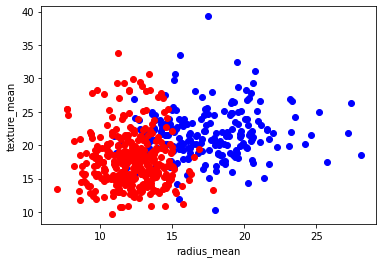

In [ ]:
mlignant = sample_df[sample_df['diagnosis']==0]
benign = sample_df[sample_df['diagnosis']==1]
plt.xlabel('radius_mean')
plt.ylabel('texture_mean')
plt.scatter(mlignant['radius_mean'], mlignant['texture_mean'], c='blue')
plt.scatter(benign['radius_mean'], benign['texture_mean'],  c='red')
plt.show()

赤（良性）と青（悪性）の点を完全に分ける直線は引けそうにないが、なるべく上手に分ける直線を引きたい。

### 2値分類
正解が2つの値（$0$と$1$とする）をとるときの分類問題を考える。
正解$y$と特徴量 $x_1, x_2, \dots, x_D$の関係をパラメータ $\mathbf{w} =(w_0, w_1, \dots, w_D)^T$ を用いて

$$
\begin{cases}
\mathbf{w}^T\mathbf{x} \geq 0 &\text{ならば}\ y = 1\\
\mathbf{w}^T\mathbf{x} < 0 &\text{ならば}\ y = 0\\
\end{cases}
$$

となるように$\mathbf{w}$を決めるのではうまく行かない。ここで、
$\mathbf{x} = (1, x_1, x_2, \dots, x_D)^T$ とおいた。

ロジスティック回帰では**シグモイド関数**

$$
\sigma(x) = \frac{1}{1+e^{-x}}
$$

を使って、

$$ 
\begin{cases}
\sigma\left(\mathbf{w}^T\mathbf{x}\right) \geq 0.5 &\text{ならば}\ y = 1 \quad (3)\\
\sigma\left(\mathbf{w}^T\mathbf{x}\right) < 0.5 &\text{ならば}\ y = 0\\
\end{cases}
$$

となるように$w_0, w_1, \dots, w_n$を決める。
シグモイド関数$\sigma(x)$は$0$以上$1$以下の値を取る関数であり、確率とみなすことができる。

[シグモイド関数の図を挿入]

つまり、今の例だと
$\sigma(\mathbf{w}^T\mathbf{x})$は$y=1$である確率を表す。
そこで、いま、クラス$C_1$, $C_2$ をそれぞれ $y=1$, $y=0$ となる事象とおいて、特徴量 $\mathbf{x}$ がクラス $C_i$（$i=1, 2$）に含まれる確率
$P(C_i | \mathbf{x} ; \mathbf{w})$ を

$$
P(C_1 | \mathbf{x} ; \mathbf{w}) = \sigma\left(\mathbf{w}^T\mathbf{x}\right)
$$

と定義する。$P(C_2 | \mathbf{x} ; \mathbf{w}) = 1 - P(C_1 | \mathbf{x} ; \mathbf{w})$ である。

例えば、計算の結果

$$
\sigma\left(\mathbf{w}^T\mathbf{x}\right) = 0.6
$$

となったときは、$y=1$となる確率が$0.6$、したがって$y=0$となる確率が$0.4$なので$y=1$と予測することになる。

係数$\mathbf{w}$は**最尤法**により推定する。

訓練データ $\{(\mathbf{x}_i,y_i)\}_{i=1,2,…,N}$ が観測される確率は

$$
P(\mathbf{w}) = \prod_{i=1}^N P(C_1 | \mathbf{x}_i ; \mathbf{w})^{y_i} (1 - P(C_1 | \mathbf{x}_i ; \mathbf{w}))^{1 - y_i}
$$

となる。
この $P(\mathbf{w})$ は尤度関数と呼ばれる。
最尤法とは尤度関数 $P(\mathbf{w})$ を最大にするパラメータ
$\mathbf{w}^*$ を推定値とする手法である。
簡単のため$P(\mathbf{w})$を最大化するのではなく、
$-\log P(\mathbf{w})$
すなわち

$$
  L(\mathbf{w}) = -\sum_{i=1}^N\left\{y_i\log(P(C_1 | \mathbf{x}_i ; \mathbf{w})) + (1 - y_i)\log(1-P(C_1 | \mathbf{x}_i ; \mathbf{w}))\right\}
$$

の最小化問題を解く。
この $L(\mathbf{w})$ がロジスティック回帰における損失関数となる．
あとは

$$
  \nabla L(\mathbf{w}) = \sum_{i=1}^N(P(C_1 | \mathbf{x}_i ; \mathbf{w}) - y_i)\mathbf{x}_i
$$

であることを使って、確率的勾配降下法などを用いて最適解 $\mathbf{w}^*$ を求めればよい。

ロジスティック回帰はscikit-learnの`LogisticRegression`クラス（https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html ） で実行できる。`SGDClassfication`クラス（https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html ）で`loss= log`オプションを指定してもよい。


特徴量と正解の作成

In [11]:
X1_df = cancer_df.drop(['diagnosis'], axis=1)
y1_df = cancer_df['diagnosis']
X1_np = X1_df.to_numpy()
y1_np = y1_df.to_numpy()

訓練データとテストデータに分ける

In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_np, y1_np)

分類問題では原則として特徴量はスケーリングする。

In [ ]:
scaler1 = StandardScaler()
scaler1.fit(X1_train)
X1_train_scaled = scaler1.transform(X1_train)
X1_test_scaled = scaler1.transform(X1_test)

LogisticRegressionの引数`C`は正則化の強さを表す係数。`Ridge`クラスなどの場合と異なり、**`C`が小さいほど正則化項の影響が強くなる**。
LogsiticRegressionクラスではデフォルトで$L^2$正則化（$\sum w_i^2$ が正則化項）を行う。

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression()
logreg.fit(X1_train_scaled, y1_train)

LogisticRegression()

係数を見てみる。

In [ ]:
colnames = X1_df.columns
pd.DataFrame(logreg.coef_.reshape(-1,1), index=colnames)

,0
radius_mean,-0.411539
texture_mean,-0.496407
perimeter_mean,-0.407902
area_mean,-0.465748
smoothness_mean,0.081338
compactness_mean,0.733878
concavity_mean,-0.735437
concave points_mean,-0.867126
symmetry_mean,-0.100873
fractal_dimension_mean,0.099019


スコアを計算する

In [ ]:
print(logreg.score(X1_test_scaled, y1_test))
print(logreg.score(X1_train_scaled, y1_train))

0.986013986013986
0.9859154929577465


新しい細胞データ

newX= [18, 10, 122, 1000, 0.1, 0.2, 0.3, 0.1, 0.2, 0.07, 1, 0.9, 8, 153, 0.006, 0.04, 0.05, 0.01, 0.03, 0.006, 25, 17, 184, 2019, 0.1, 0.6, 0.7, 0.2, 0.4, 0.1]

が悪性（0）から良性（1）か調べる。

In [ ]:
newX= np.array([18, 10, 122, 1000, 0.1, 0.2, 0.3, 0.1, 0.2, 0.07, 1, 0.9, 8, 153, 0.006, 0.04, 0.05, 0.01, 0.03, 0.006, 25, 17, 184, 2019, 0.1, 0.6, 0.7, 0.2, 0.4, 0.1]).reshape(1,-1)

In [ ]:
newX_scaled = scaler1.transform(newX)

In [ ]:
logreg.predict(newX_scaled)

array([0])

In [ ]:
logreg.predict_proba(newX_scaled)

array([[9.99999801e-01, 1.98539213e-07]])

悪性であることが分かる。

### 多クラス分類
アヤメ（iris）のデータ [iris.csv](https://drive.google.com/file/d/10Bjm4kA8f-Bg2DiKgPcJSXq7gJF4gHOA/view?usp=sharing)を使ってアヤメの品種分類を行う。3つの品種があるので、**多クラス分類**となる。
このデータはアヤメの特徴

- Sepal Length がく片の長さ
- Sepal Width がく片の幅
- Petal length 花びらの長さ
- petal Width 花びらの幅

と、その品種

0. Setosa 
1. Versicolor
2. Virginica

が含まれている。これらの特徴量から品種をロジスティック回帰を使って予測したい。

多クラス分類の場合はシグモイド関数の代わりに**ソフトマックス関数**を使って、係数を推定する。一般に、$K$クラス分類の場合には $K$ 個の線形関数
$y_k =\mathbf{w}_k^T \mathbf{x}$
を用いて識別をする。
ここで、$\mathbf{w}_k=(w_{k0},w_{k1},…,w_{kD})^T$ である。
この場合には、シグモイド関数の代わりにソフトマックス関数を使って

$$
  P(C_k|\mathbf{x}) = \frac{\exp\left(\mathbf{w}_k^T \mathbf{x}\right)}{\sum_{j=1}^K \exp\left(\mathbf{w}_j^T \mathbf{x}\right)}
$$

として、最尤法を用いてパラメータ$\{\mathbf{w}_k^*\}_{k=1,…,K}$
を推定すればよい。
そして，特徴量$\mathbf{x}$を$\mathbf{w}_k^*$を用いて計算した
$P(C_k|\mathbf{x})$が最も大きくなるクラスに分類すればよい．

多クラス分類になっても `LogisticRegression`の使い方はほとんど変わらない。


irisデータの読み込みと先頭の確認。

In [ ]:
iris_df = pd.read_csv('')

In [ ]:
iris_df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


データの図示する。ここでは、seabornライブラリの`pairplot`を使ってみる。https://seaborn.pydata.org/generated/seaborn.pairplot.html

In [ ]:
import seaborn as sns

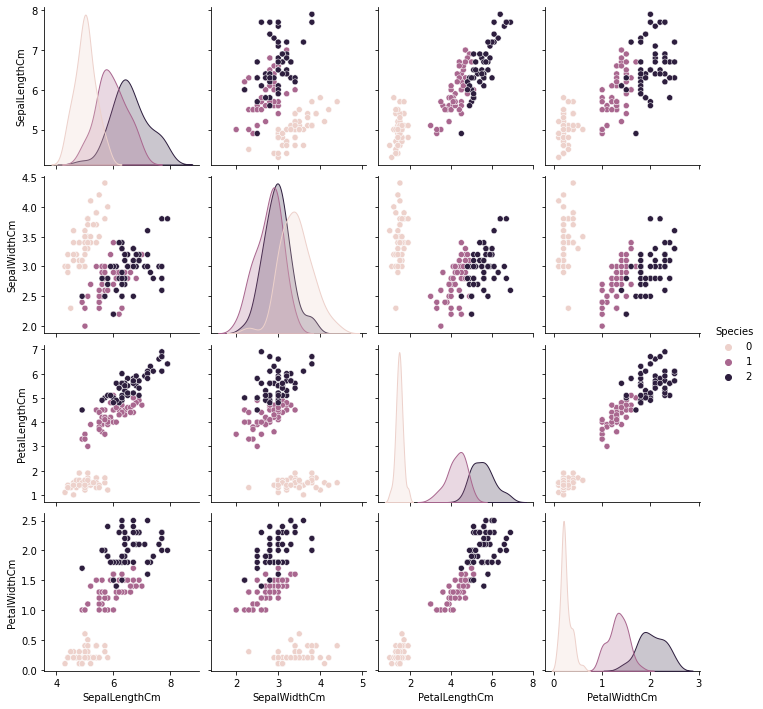

In [ ]:
sns.pairplot(iris_df, hue='Species')

特徴量と正解の作成。`Species`が正解になる。

In [ ]:
X2_df = iris_df.drop(['Species'], axis=1)
y2_df = iris_df['Species']
X2_np = np.array(X2_df)
y2_np = np.array(y2_df)

訓練データとテストデータに分ける

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_np, y2_np)

特徴量のスケーリング

In [ ]:
scaler2 = StandardScaler()
scaler2.fit(X2_train)
X2_train_scaled = scaler2.transform(X2_train)
X2_test_scaled = scaler2.transform(X2_test)

ロジスティック回帰の実行

In [ ]:
logreg2 = LogisticRegression()
logreg2.fit(X2_train_scaled, y2_train)

LogisticRegression()

係数の表示。3つの係数の組み合わせが3つあることに注意。3本の直線で分類をしていることを表す。

In [ ]:
print(logreg2.coef_)
print(logreg2.intercept_)

[[-1.01571659  1.02410111 -1.75072341 -1.63287316]
 [ 0.62231946 -0.38976498 -0.29342776 -0.80609972]
 [ 0.39339713 -0.63433613  2.04415117  2.43897288]]
[-0.39408557  1.71061118 -1.31652561]


スコアの計算

In [ ]:
print(logreg2.score(X2_test_scaled, y2_test))
print(logreg2.score(X2_train_scaled, y2_train))

0.9736842105263158
0.9732142857142857


## 教師なし学習: k-means法によるクラスタリング

正解が与えられないデータに関する学習を**教師なし学習**という。教師なし学習にはクラスタリングや次元削減などのタスクがある。ここでは、クラスタリングを扱う。クラスタリングは与えられたデータを、類似したデータ群に分割することである。

**k-means法**によりクラスタリングを行う。k-means法は以下のアルゴリズムによりデータを分割する。k-means法では何個のクラスタに分割するか、あらかじめ決めておく必要がある。$K$個のクラスタに分割するとする。また、データは$D$個の特徴量を持つとする。

1. $K$個のクラスタの重心$\mu_k$（$k=1, 2, \dots, K$）をランダムに選ぶ。
2. 各データ$\mathbf{x}_n$を最も近い重心$\mu_k$のクラスタに割り当てる。すなわち、$\mathbf{x}_n$のクラスタを $z_n^* = \mathop{argmin}_k \sum_{j=1}^D(x_{jn} - \mu_{jk})^2$ とする。
3. こうしてできたクラスタの重心を新たに $\mu_k = \frac{1}{N_k}\sum_{n: z_n = k}\mathbf{x}_n$と定義する。$N_k$はクラスタ$k$に含まれるデータの個数。
4. クラスタの割合が変化しなくなるまで、2と3を繰り返す。

scikit-learnライブラリの`KMeans`クラスでk-means法を実行できる。irisデータを3つのクラスタに分割してみよう。

一般にはスケーリングしたほうがよいが、irisデータはほぼスケールが揃っているので、ここでは省略する。


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X2_np)

KMeans(n_clusters=4)

結果を表示

In [ ]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1,
       3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1,
       3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2,
       1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1], dtype=int32)

正解と比較

In [ ]:
y2_np

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

散布図を描くために、特徴量`X3_df`と結果`labels`を1つのデータフレームにまとめる。

In [ ]:
labels = kmeans.labels_
result_df = pd.concat([X2_df, pd.DataFrame(labels, columns=['result'])], axis=1)

In [ ]:
result_df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,result
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


seabornライブラリの`pairplot`で散布図を描く。

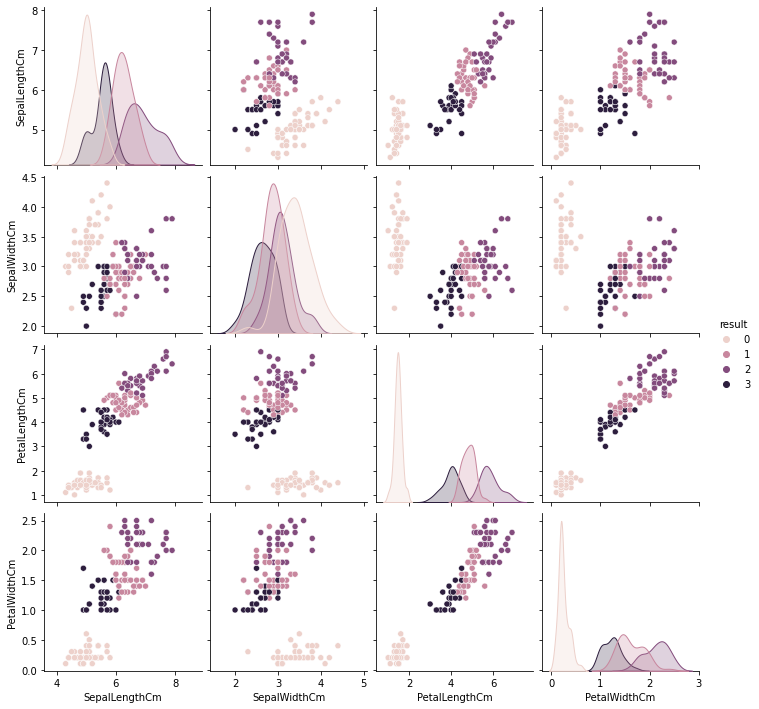

In [ ]:
sns.pairplot(result_df, hue='result')

k-means法の問題として、あらかじめクラスタの数$K$を指定しなければならないことがある。
クラスタリングの良さの指標として慣性（inertia）が使われる。慣性とは各データと最短重心の二乗距離の和である。
各データが最短重心に近いほど、慣性は小さくなる。

クラスタ数$K$と慣性の関係を調べて、慣性があまり減少しなくなる$K$（エルボー）
を選ぶ。

In [ ]:
inertia_data = np.zeros(10)
for k in range(10):
    kmeans = KMeans(n_clusters=k+1, random_state=123)
    kmeans.fit(X2_np)
    inertia_data[k] = kmeans.inertia_

グラフを描く

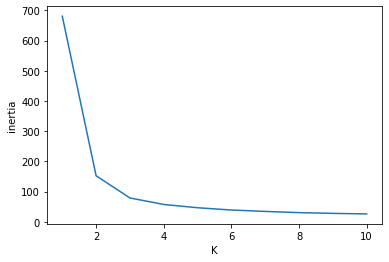

In [ ]:
x = np.arange(1, 11)
plt.xlabel('K')
plt.ylabel('inertia')
plt.plot(x, inertia_data)
plt.show()

$K=3$あたりから慣性があまり減少しなくなる。